# The TikTok-to-Spotify Pipeline
**TXC Group X**<br>
Leticia Brendle - 70033 <br>
Francesco Ciorciolini - 73166 <br>
X<br>


Repository: https://github.com/letti70033/spotify-tiktok-analysis

## Table of Content

[1. Executive Summary](#1-executive-summary)

[2. Introduction](#2-introduction)
- [2.1 Dataset Description](#21-dataset-description)
- [2.2 Research Question](#22-research-question)  
- [2.3 Hypotheses](#23-hypotheses)
- [2.4 Analysis Plan](#24-analysis-plan)

[3. Exploratory Data Analysis](#3-exploratory-data-analysis)
- [3.1 Data Set Up](#31-data-set-up)
- [3.2 Data Cleaning](#32-data-cleaning)
- [3.3 Types of Variables](#33-types-of-variables)
- [3.4 Descriptive Statistics](#34-descriptive-statistics)
  - [3.4.1 Univariate Analysis](#341-univariate-analysis)
  - [3.4.2 Bivariate Analysis](#342-bivariate-analysis)
- [3.5 Key Findings](#35-key-findings)

[4. Method 1: Cluster Analysis](#4-method-1-cluster-analysis)

[5. Method 2: Polynomial Regression](#5-method-2-polynomial-regression)

[6. Reflection on AI Use](#6-reflection-on-ai-use)

[7. Conclusion](#7-conclusion)

*notes from prof (sheet): *
The Notebook must include at least the following sections:
1. Executive Summary – A short summary that highlights the goal of the project and core findings.
2. Introduction – A section that describes (in words) the dataset and variables. This section should
clearly state the research question(s) and the related hypotheses and describe a plan to test them.
3. Exploratory data analysis – A section that uses different statistical metrics and visualizations to
describe the data set and presents the first descriptive insights.


3.1 Types of variables
3.2 Descriptive Statistics
3.2.1 Frequencies
3.2.2 Measures of central tendency
3.2.3 Correlations
3.2.4 Summary statistics table

4. Method 1 – This section should describe why a specific method (e.g., t-test, linear regression,
logistic regression, cluster analysis, factor analysis, time series model, or panel regression) is used
to test a hypothesis. It should apply the method to the data set, check the most important
assumptions, and provide an interpretation of the results obtained (i.e., what did we learn about
the hypotheses, and how good is the model).
5. Method 2 – This section should contain the same information as the previous section, but with
another method to test a different hypothesis.
6. Reflection on use of AI – This section is dedicated to discussing the use of AI, should detail what
AI models were used, for what tasks AI was used, how it was used (e.g., prompt examples), and
what value the students contributed beyond the tasks the AI completed (e.g., what instructions
were crucial to improve the quality of the project, what approaches did not work, etc.).
7. Conclusion – This section should discuss the findings and explain what we learned about the
research question. Further, it should discuss the chosen approach's limitations and ways to
improve the analysis.

TODO before DONE:
- check all values that are hard written in conclusions
- take out notes above
- code comments review-> easy/understandable and not clearly from AI
- same wordws: engagement metrics / popularity metric?? vs dependent variable Spotify Popularity, + take Tik Tok Views to reduce redundancy (not Likes!!) 

## 1. Executive Summary

Previous research might assume TikTok virality directly translates to streaming success. 
However, we observe only weak correlations (ρ = 0.26-0.33) between TikTok engagement 
and Spotify streams. This weak relationship is precisely what motivates our research: 
we hypothesize that this is due to a 'ceiling effect' where extreme TikTok virality 
creates diminishing returns, explaining why the overall correlation remains modest."



*Why Novel: Tests the counterintuitive idea that TikTok success might actually limit rather than enhance long-term success*
*Business Relevance: Critical for music industry investment and artist development strategies*

## 2. Introduction



### 2.1 Dataset Description
The dataset used in this project comes from <i> Spotify’s most streamed songs in 2024</i>, enriched with information related to TikTok activity and engagement metrics. It includes both musical characteristics, such as streams and popularity on Spotify) and social media engagement indicators, as TikTok posts, likes, and views. This combination allows us to analyze the relationship between streaming platforms and social media virality, in particular Spotify and TikTok respectively.

#### Spotify Most Streamed Songs in 2024 Dataset
**Track** : The title of the song<br>
**Artist** : The artist(s) of the song<br>
**Release Date** : The official release date of the track<br>
**Spotify Streams** : The total number of times the song has been streamed on Spotify<br>
**Spotify Popularity** : A numerical score (0–100) assigned by Spotify, which reflects both recent and historical streaming activity<br>
**Spotify Playlist Count** : The number of playlists on Spotify that include the track<br>
**TikTok Posts** : The number of TikTok videos created using the song as background music<br>
**TikTok Likes** : The total number of likes received by TikTok videos featuring the song<br>
**TikTok Views** : The total number of views generated by TikTok videos using the track<br>
**Track Score** : A composite score that combines multiple dimensions of success (streams, TikTok metrics, popularity) to give an overall performance indicator<br>
**All Time Rank** : The position of the track in the ranking of Spotify’s most streamed songs of all time<br>

Why this dataset is relevant for the research?


### 2.2 Research Question
The goal of this research is to better understand the question:
#### **Does TikTok virality create a 'popularity ceiling' effect? Investigating how TikTok engagement patterns predict and limit long-term streaming success across Spotify.**
To answer this question, we have formulated two hypotheses which will be tested:




### 2.3 Hypotheses

#### Hypothesis 1: **Diminishing Returns Hypothesis**. Songs with extremely high TikTok engagement (top 10%) show diminishing returns on Spotify long-term streaming compared to moderate TikTok performers

- **Null Hypothesis (H₀):** .
- **Alternative Hypothesis (H₁):** .

-> Being "too viral" on TikTok might actually hurt long-term Spotify success

<br>

#### Hypothesis 2: **Inverted U-Shape Hypothesis**. The TikTok-Spotify conversion rate follows an inverted U-shape, with optimal TikTok engagement existing in the middle range 

- **Null Hypothesis (H₀):** .
- **Alternative Hypothesis (H₁):**  .

-> There's a "sweet spot" - moderate TikTok success converts best to Spotify streams



### 2.4 Analysis Plan


*Methods:*

H1/ Method 1: K-Means Cluster Analysis 

What: Cluster songs based on TikTok metrics (views, likes, posts) and Spotify streams
Expected clusters:

"TikTok-only viral" (high TikTok, low Spotify) ← evidence for H1
"Balanced success" (moderate TikTok, high Spotify) ← the sweet spot
"Spotify dominant" (low TikTok, high Spotify)
"Low performers" (low on both)


Analysis: Compare Spotify performance across clusters, especially top TikTok performers vs. moderate
Methods: Elbow method for optimal k, silhouette score for cluster quality

H2 /Method 2: Polynomial Regression 

What: Run regression with TikTok engagement as predictor and Spotify streams as outcome
Include: Quadratic term (TikTok²) to test for non-linear, inverted U-shaped relationship
Interpretation: If quadratic term is negative and significant → confirms inverted U-shape
Assumptions to check: Linearity (for polynomial), homoscedasticity, normality of residuals, no multicollinearity

## 3. Exploratory Data Analysis

Before testing our hypotheses and creating further statistical models, we start with **an exploratory data analysis (EDA)**. 
In this step we try to understand what type of variables we have in our data set, how they are distributed, and if we can already spot some patterns regarding their joint distribution.

we will try to:

- Understand types of variables 
- Descriptive statistics of individual variables
- Descriptive statistics of correlations

### 3.1 Data Set Up
Before we start with our EDA, we will import all the necessary libraries as well as our data sets. We will also have a first look at the structure of the data to help us understand it.

In [43]:
# import libraries
# Data
import pandas as pd 
import numpy as np

# Graphs
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Load CSV file 
spotify_songs = pd.read_csv('Most Streamed Spotify Songs 2024.csv', encoding='cp1252')

# Data Overview 
print(spotify_songs.head())
print(f"Dataset size: {spotify_songs.shape[0]} rows, {spotify_songs.shape[1]} columns")


                        Track                    Album Name          Artist  \
0         MILLION DOLLAR BABY  Million Dollar Baby - Single   Tommy Richman   
1                 Not Like Us                   Not Like Us  Kendrick Lamar   
2  i like the way you kiss me    I like the way you kiss me         Artemas   
3                     Flowers              Flowers - Single     Miley Cyrus   
4                     Houdini                       Houdini          Eminem   

  Release Date          ISRC All Time Rank  Track Score Spotify Streams  \
0    4/26/2024  QM24S2402528             1        725.4     390,470,936   
1     5/4/2024  USUG12400910             2        545.9     323,703,884   
2    3/19/2024  QZJ842400387             3        538.4     601,309,283   
3    1/12/2023  USSM12209777             4        444.9   2,031,280,633   
4    5/31/2024  USUG12403398             5        423.3     107,034,922   

  Spotify Playlist Count Spotify Playlist Reach  ...  SiriusXM Spins  \
0 

### 3.2 Data Cleaning

Now we will clean our dataset, to be able to get meaningful results from our EDA. We will drop unnecessary columns, remove missing values and remove duplicates.

#### Drop unnecessary columns

After preparing the data we now remove all unnecessary columns.This ensures that we can focus on the variables that are relevant for our analysis while also making our data set smaller which speeds up the analysis.

We dont need all columns of our dataset, as we just want to focus on the popularity of the songs, and the two platforms spotify and Tik Tok. So, we will just have a look at following variables:'Track', 'Artist', 'Spotify Streams', 'Spotify Popularity', 'Spotify Playlist Count', 
    'TikTok Posts', 'TikTok Likes', 'TikTok Views',
    'Track Score', 'All Time Rank'

In [44]:
# define TikTok-to-Spotify relevant columns
relevant_columns = [
    'Track', 'Artist','Spotify Streams', 'Spotify Popularity', 'Spotify Playlist Count', 
    'TikTok Posts', 'TikTok Likes', 'TikTok Views',
    'Track Score', 'All Time Rank'
]

print(f"Keeping {len(relevant_columns)} relevant columns from {spotify_songs.shape[1]} total columns:")
for col in relevant_columns:
    print(f"  • {col}")

# drop other columns
songs_clean_columns = spotify_songs[relevant_columns].copy()

#overview of data with relevant columns
print(songs_clean_columns.head())
print(f"\nDataset after dropping columns: {songs_clean_columns.shape[0]} rows, {songs_clean_columns.shape[1]} columns")


Keeping 10 relevant columns from 29 total columns:
  • Track
  • Artist
  • Spotify Streams
  • Spotify Popularity
  • Spotify Playlist Count
  • TikTok Posts
  • TikTok Likes
  • TikTok Views
  • Track Score
  • All Time Rank
                        Track          Artist Spotify Streams  \
0         MILLION DOLLAR BABY   Tommy Richman     390,470,936   
1                 Not Like Us  Kendrick Lamar     323,703,884   
2  i like the way you kiss me         Artemas     601,309,283   
3                     Flowers     Miley Cyrus   2,031,280,633   
4                     Houdini          Eminem     107,034,922   

   Spotify Popularity Spotify Playlist Count TikTok Posts   TikTok Likes  \
0                92.0                 30,716    5,767,700    651,565,900   
1                92.0                 28,113      674,700     35,223,547   
2                92.0                 54,331    3,025,400    275,154,237   
3                85.0                269,802    7,189,811  1,078,757,968   
4 

Now our dataset looks leaner.

#### Remove missing values

In this step we make sure that any rows containing null values are removed from the data set.

In [45]:
# see how many/where missing values there are
missing_summary = songs_clean_columns.isnull().sum()
missing_percentage = (missing_summary / len(songs_clean_columns)) * 100

print("Missing values per column:")
for col in songs_clean_columns.columns:
    missing_count = missing_summary[col]
    missing_pct = missing_percentage[col]
    print(f"  {col}: {missing_count} ({missing_pct:.1f}%)")

# Drop rows with missing values+ Overview
bef_mis_values = len(songs_clean_columns)
print(f"\nRows before dropping missing values: {bef_mis_values}")
songs_clean_missing_na = songs_clean_columns.dropna()
aft_mis_values = len(songs_clean_missing_na)
print(f"Rows after dropping missing values: {aft_mis_values}")
print(f"Total number of missing values dropped: {bef_mis_values-aft_mis_values}")

Missing values per column:
  Track: 0 (0.0%)
  Artist: 5 (0.1%)
  Spotify Streams: 113 (2.5%)
  Spotify Popularity: 804 (17.5%)
  Spotify Playlist Count: 70 (1.5%)
  TikTok Posts: 1173 (25.5%)
  TikTok Likes: 980 (21.3%)
  TikTok Views: 981 (21.3%)
  Track Score: 0 (0.0%)
  All Time Rank: 0 (0.0%)

Rows before dropping missing values: 4600
Rows after dropping missing values: 3171
Total number of missing values dropped: 1429


#### Values of same type

Furthermore, we must ensure that all columns contain values of the same type (our numeric values float and not string).

In [46]:
# identify numeric columns
numeric_columns = [
    'Spotify Streams', 'Spotify Popularity', 'Spotify Playlist Count',
    'TikTok Posts', 'TikTok Likes', 'TikTok Views', 
    'Track Score', 'All Time Rank'
]

# convert string numbers to numeric
for col in numeric_columns:
    if col in songs_clean_columns.columns:
        # remove , 
        songs_clean_columns[col] = songs_clean_columns[col].astype(str).str.replace(',', '').str.replace(' ', '')
        songs_clean_columns[col] = pd.to_numeric(songs_clean_columns[col], errors='coerce')

#### Remove Duplicates

Duplicates must also be removed from the dataset as they would bias our analysis. We are checking for duplicates based on Track + Artist combination.

In [47]:
#check for duplictes based on Track + Artist combination
duplicates_before = songs_clean_columns.duplicated(subset=['Track', 'Artist']).sum()
bef_dupl = len(songs_clean_columns)

print(f"Duplicate songs found: {duplicates_before}")

if duplicates_before > 0:
    
    print("\nDuplicated songs:")
    duplicate_songs = songs_clean_columns[songs_clean_columns.duplicated(subset=['Track', 'Artist'], keep=False)]
    duplicate_examples = duplicate_songs.groupby(['Track', 'Artist']).size().head()
    for (track, artist), count in duplicate_examples.items():
        print(f"  '{track}' by {artist}: {count} entries")
    
    # drop duplicates
    bef_dupl = len(songs_clean_columns)
    songs_clean_duplicates = songs_clean_columns.drop_duplicates(subset=['Track', 'Artist'], keep='first')
    aft_dupl = len(songs_clean_duplicates)
else:
    print("No duplicates found!")


# Overview of dropped duplicates
duplicates_after = songs_clean_duplicates.duplicated(subset=['Track', 'Artist']).sum()
print(f"Remaining duplicates after dropping: {duplicates_after}")
print(f"\nRows before dropping duplicateds: {bef_dupl}")
print(f"Rows after dropping duplictes: {aft_dupl}")
print(f"Total number of duplicates dropped: {bef_dupl - aft_dupl}")

# Save cleaned dataset
songs_clean_duplicates.to_csv('spotify_cleaned.csv', index=False)
print(f"\nCleaned dataset saved as 'spotifysongs_cleaned.csv'")

Duplicate songs found: 112

Duplicated songs:
  '2002' by Anne-Marie: 2 entries
  '24K Magic' by Bruno Mars: 2 entries
  'A Bar Song (Tipsy)' by Shaboozey: 2 entries
  'About Damn Time' by Lizzo: 2 entries
  'Animals' by Martin Garrix: 2 entries
Remaining duplicates after dropping: 0

Rows before dropping duplicateds: 4600
Rows after dropping duplictes: 4488
Total number of duplicates dropped: 112

Cleaned dataset saved as 'spotifysongs_cleaned.csv'


#### Final Data Set Up

Data cleaning was necessary to make the dataset consistent and reliable. We removed unnecessary columns to reduce noise, dropped missing values to avoid bias in statistical calculations, and eliminated duplicate entries (based on track–artist combinations) to prevent overrepresentation of certain observations. After this process, the dataset is well-structured for our descriptive and inferential analysis. Now we can set up our working dataset.

In [48]:
#override our datset
spotify_songs = pd.read_csv('spotify_cleaned.csv', encoding='cp1252')

#rename columns to be able to use them
spotify_songs.columns = spotify_songs.columns.str.replace(' ', '_')
print(spotify_songs.dtypes)

# Data Overview 
print(spotify_songs.head())
print(f"Dataset size: {spotify_songs.shape[0]} rows, {spotify_songs.shape[1]} columns")

Track                      object
Artist                     object
Spotify_Streams           float64
Spotify_Popularity        float64
Spotify_Playlist_Count    float64
TikTok_Posts              float64
TikTok_Likes              float64
TikTok_Views              float64
Track_Score               float64
All_Time_Rank               int64
dtype: object
                        Track          Artist  Spotify_Streams  \
0         MILLION DOLLAR BABY   Tommy Richman     3.904709e+08   
1                 Not Like Us  Kendrick Lamar     3.237039e+08   
2  i like the way you kiss me         Artemas     6.013093e+08   
3                     Flowers     Miley Cyrus     2.031281e+09   
4                     Houdini          Eminem     1.070349e+08   

   Spotify_Popularity  Spotify_Playlist_Count  TikTok_Posts  TikTok_Likes  \
0                92.0                 30716.0     5767700.0  6.515659e+08   
1                92.0                 28113.0      674700.0  3.522355e+07   
2                9

#### 3.3 Types of Variables

Now let's have a look at our variables, to get a good understanding of the dataset before the EDA.

In [49]:
spotify_songs.columns

Index(['Track', 'Artist', 'Spotify_Streams', 'Spotify_Popularity',
       'Spotify_Playlist_Count', 'TikTok_Posts', 'TikTok_Likes',
       'TikTok_Views', 'Track_Score', 'All_Time_Rank'],
      dtype='object')

#### Nominal, ordinal and binary variables

In [50]:
print(spotify_songs.Track.unique())
print(spotify_songs.Artist.unique())
print(spotify_songs.All_Time_Rank.unique())

['MILLION DOLLAR BABY' 'Not Like Us' 'i like the way you kiss me' ...
 'Grace (feat. 42 Dugg)' 'Nashe Si Chadh Gayi'
 'Me Acostumbre (feat. Bad Bunny)']
['Tommy Richman' 'Kendrick Lamar' 'Artemas' ... 'Kerim Araz'
 'Jaques RaupÃ¯Â¿' 'BUSHIDO ZHO']
[   1    2    3 ... 4571 4591 4593]


In [51]:
spotify_songs.Spotify_Streams.unique()
spotify_songs.Spotify_Streams.min()

np.float64(1071.0)

#### Continous variables

In [52]:
print('Spotify_Streams')
print(f"Range: {spotify_songs.Spotify_Streams.min()} - {spotify_songs.Spotify_Streams.max()}\n")


print('Spotify_Popularity')
print(f"Range: {spotify_songs.Spotify_Popularity.min()} - {spotify_songs.Spotify_Popularity.max()}\n")

print('TikTok_Views')
print(f"Range: {spotify_songs.TikTok_Views.min()} - {spotify_songs.TikTok_Views.max()}\n")

print('TikTok_Likes')
print(f"Range: {spotify_songs.TikTok_Likes.min()} - {spotify_songs.TikTok_Likes.max()}\n")


Spotify_Streams
Range: 1071.0 - 4281468720.0

Spotify_Popularity
Range: 1.0 - 96.0

TikTok_Views
Range: 19.0 - 233232311463.0

TikTok_Likes
Range: 3.0 - 23474223833.0



Our dataset contains a mix of categorical variables that describe the song (track, artist) and numerical variables that describe their popularity (streams, views, likes, popularity scores). Spotify Popularity is alreadey normalised, so we will take this as dependent variable for our Research.

### 3.4 Descriptive Statistics

For our EDA we will focus on these 4 numeric variables: Spotify Streams, Spotify Popularity, Tik Tok Views and Tik Tok Likes, as these are our variables that are important for testing our hypotheses. First we will have a look at the variables individually and in the second part how they interact, to be able to recognize first patterns.

To be able to seperate both platforms in graphs better, Spotify Data will be displayed in green colours and TikTtok Data in red colours.

#### 3.4.1 Univariate Analysis

##### Measures of central tendency

**Min, Max, Range**

In [53]:
print('Spotify_Streams')
print(spotify_songs.Spotify_Streams.min())
print(spotify_songs.Spotify_Streams.max())
print(f"Range: {spotify_songs.Spotify_Streams.min()} - {spotify_songs.Spotify_Streams.max()}\n")


print('Spotify_Popularity')
print(spotify_songs.Spotify_Popularity.min())
print(spotify_songs.Spotify_Popularity.max())
print(f"Range: {spotify_songs.Spotify_Popularity.min()} - {spotify_songs.Spotify_Popularity.max()}\n")

print('TikTok_Views')
print(spotify_songs.TikTok_Views.min())
print(spotify_songs.TikTok_Views.max())
print(f"Range: {spotify_songs.TikTok_Views.min()} - {spotify_songs.TikTok_Views.max()}\n")

print('TikTok_Likes')
print(spotify_songs.TikTok_Likes.min())
print(spotify_songs.TikTok_Likes.max())
print(f"Range: {spotify_songs.TikTok_Likes.min()} - {spotify_songs.TikTok_Likes.max()}\n")

Spotify_Streams
1071.0
4281468720.0
Range: 1071.0 - 4281468720.0

Spotify_Popularity
1.0
96.0
Range: 1.0 - 96.0

TikTok_Views
19.0
233232311463.0
Range: 19.0 - 233232311463.0

TikTok_Likes
3.0
23474223833.0
Range: 3.0 - 23474223833.0



**Mean, median, mode, quantiles**

In [54]:

# Spotify Streams
mean_spotify_streams = spotify_songs['Spotify_Streams'].mean()
median_spotify_streams = spotify_songs['Spotify_Streams'].median()
q25_spotify_streams = spotify_songs['Spotify_Streams'].quantile(0.25)
q75_spotify_streams = spotify_songs['Spotify_Streams'].quantile(0.75)
mode_spotify_streams = spotify_songs['Spotify_Streams'].mode()

# Spotify Popularity
mean_spotify_popularity = spotify_songs['Spotify_Popularity'].mean()
median_spotify_popularity = spotify_songs['Spotify_Popularity'].median()
q25_spotify_popularity = spotify_songs['Spotify_Popularity'].quantile(0.25)
q75_spotify_popularity = spotify_songs['Spotify_Popularity'].quantile(0.75)
mode_spotify_popularity = spotify_songs['Spotify_Popularity'].mode()

# TikTok Likes
mean_tiktok_likes = spotify_songs['TikTok_Likes'].mean()
median_tiktok_likes = spotify_songs['TikTok_Likes'].median()
q25_tiktok_likes = spotify_songs['TikTok_Likes'].quantile(0.25)
q75_tiktok_likes = spotify_songs['TikTok_Likes'].quantile(0.75)
mode_tiktok_likes = spotify_songs['TikTok_Likes'].mode()

# TikTok Views
mean_tiktok_views = spotify_songs['TikTok_Views'].mean()
median_tiktok_views = spotify_songs['TikTok_Views'].median()
q25_tiktok_views = spotify_songs['TikTok_Views'].quantile(0.25)
q75_tiktok_views = spotify_songs['TikTok_Views'].quantile(0.75)
mode_tiktok_views = spotify_songs['TikTok_Views'].mode()

# Print the results
print("\nSpotify Streams:")
print(f" Mean: {mean_spotify_streams:,.0f}")
print(f" Median: {median_spotify_streams:,.0f}")
print(f" 25th percentile: {q25_spotify_streams:,.0f}")
print(f" 75th percentile: {q75_spotify_streams:,.0f}")
print(f" Mode: {mode_spotify_streams.values[0] if len(mode_spotify_streams) > 0 else 'N/A'}\n")

print("Spotify Popularity:")
print(f" Mean: {mean_spotify_popularity:.2f}")
print(f" Median: {median_spotify_popularity}")
print(f" 25th percentile: {q25_spotify_popularity}")
print(f" 75th percentile: {q75_spotify_popularity}")
print(f" Mode: {mode_spotify_popularity.values[0] if len(mode_spotify_popularity) > 0 else 'N/A'}\n")

print("TikTok Likes:")
print(f" Mean: {mean_tiktok_likes:,.0f}")
print(f" Median: {median_tiktok_likes:,.0f}")
print(f" 25th percentile: {q25_tiktok_likes:,.0f}")
print(f" 75th percentile: {q75_tiktok_likes:,.0f}")
print(f" Mode: {mode_tiktok_likes.values[0] if len(mode_tiktok_likes) > 0 else 'N/A'}\n")

print("TikTok Views:")
print(f" Mean: {mean_tiktok_views:,.0f}")
print(f" Median: {median_tiktok_views:,.0f}")
print(f" 25th percentile: {q25_tiktok_views:,.0f}")
print(f" 75th percentile: {q75_tiktok_views:,.0f}")
print(f" Mode: {mode_tiktok_views.values[0] if len(mode_tiktok_views) > 0 else 'N/A'}\n")



Spotify Streams:
 Mean: 432,476,535
 Median: 231,434,956
 25th percentile: 68,355,458
 75th percentile: 606,244,551
 Mode: 50652672.0

Spotify Popularity:
 Mean: 63.63
 Median: 67.0
 25th percentile: 61.0
 75th percentile: 73.0
 Mode: 67.0

TikTok Likes:
 Mean: 112,385,962
 Median: 26,425,826
 25th percentile: 5,798,312
 75th percentile: 93,181,013
 Mode: 42.0

TikTok Views:
 Mean: 1,156,641,907
 Median: 264,112,132
 25th percentile: 58,330,764
 75th percentile: 913,416,942
 Mode: 1200000.0



**Variance and Standard Deviation**

In [55]:

# Compute variance and standard deviation for Spotify Streams
spotify_streams_variance = spotify_songs['Spotify_Streams'].var()
spotify_streams_std_dev = spotify_songs['Spotify_Streams'].std()

# Compute variance and standard deviation for Spotify Popularity
spotify_popularity_variance = spotify_songs['Spotify_Popularity'].var()
spotify_popularity_std_dev = spotify_songs['Spotify_Popularity'].std()

# Compute variance and standard deviation for TikTok Views
tiktok_views_variance = spotify_songs['TikTok_Views'].var()
tiktok_views_std_dev = spotify_songs['TikTok_Views'].std()

# Compute variance and standard deviation for TikTok Likes
tiktok_likes_variance = spotify_songs['TikTok_Likes'].var()
tiktok_likes_std_dev = spotify_songs['TikTok_Likes'].std()

# Print the results
print("\nSpotify Streams:")
print(f" Variance: {spotify_streams_variance:.2e}")
print(f" Standard Deviation: {spotify_streams_std_dev:,.0f}\n")

print("Spotify Popularity:")
print(f" Variance: {spotify_popularity_variance:.2f}")
print(f" Standard Deviation: {spotify_popularity_std_dev:.2f}\n")

print("TikTok Views:")
print(f" Variance: {tiktok_views_variance:.2e}")
print(f" Standard Deviation: {tiktok_views_std_dev:,.0f}\n")

print("TikTok Likes:")
print(f" Variance: {tiktok_likes_variance:.2e}")
print(f" Standard Deviation: {tiktok_likes_std_dev:,.0f}")




Spotify Streams:
 Variance: 2.73e+17
 Standard Deviation: 522,633,828

Spotify Popularity:
 Variance: 257.21
 Standard Deviation: 16.04

TikTok Views:
 Variance: 3.47e+19
 Standard Deviation: 5,891,537,842

TikTok Likes:
 Variance: 3.04e+17
 Standard Deviation: 551,166,331


CHECK NUMBERS AT END


Based on the descriptive statistics, several key patterns emerge:

- **Extreme right-skewness across all engagement metrics:** Means substantially exceed medians (e.g., TikTok Likes mean: 112M vs median: 26M), revealing a power-law distribution where a small number of viral outliers drive aggregate totals while most songs receive minimal engagement.

- **Exceptionally high variance indicates winner-take-all dynamics:** Standard deviations exceed or equal means for all raw metrics (Spotify Streams SD: 523M, TikTok Views SD: 5.9B), with TikTok showing even greater dispersion than Spotify. This extreme inequality creates ideal conditions for testing our ceiling effect hypothesis.

- **TikTok's coefficient of variation (CV=5.24) exceeds Spotify's (CV=1.21):** This suggests TikTok success is more unpredictable and concentrated among fewer hits. The higher volatility raises critical questions about whether extreme TikTok virality translates efficiently into sustained Spotify streaming success or if it represents ephemeral attention.

- **Spotify Popularity shows moderate variance (SD=16.04, CV=0.25):** Unlike raw counts, this normalized metric exhibits a more stable distribution, making it suitable as the dependent variable for regression analysis without transformation.

- **Log transformation required for regression:** The massive skewness and heteroscedasticity in raw engagement metrics necessitate log transformation to meet normality assumptions and reduce outlier influence in subsequent polynomial regression analysis.

To get a feeling of how the means really substantially exceed the medians for TikTok Likes, Views and Spotify Streams lets look at this Bar Chart:

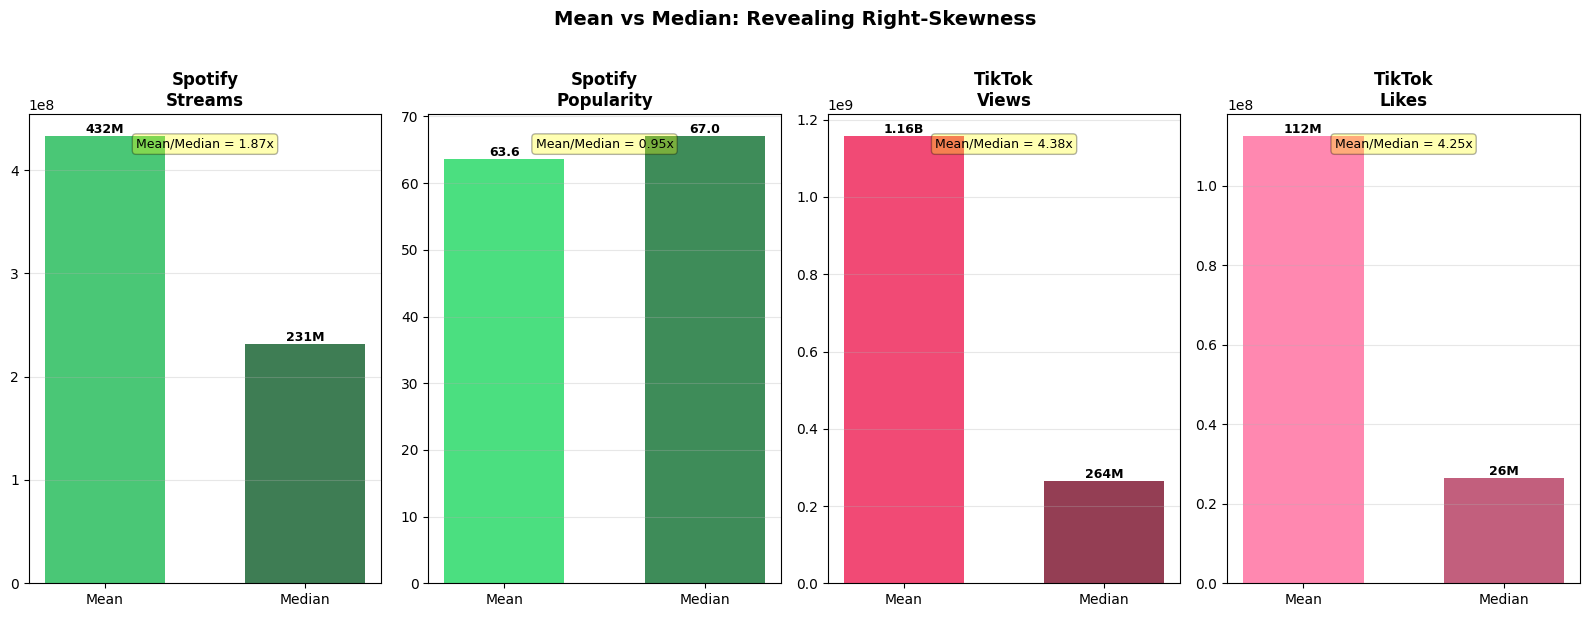

In [56]:
# Simple bar plot: Mean vs Median (shows Skewness)

metrics = ['Spotify\nStreams', 'Spotify\nPopularity', 'TikTok\nViews', 'TikTok\nLikes']

# Calculate means and medians
means = [
    spotify_songs['Spotify_Streams'].mean(),
    spotify_songs['Spotify_Popularity'].mean(),
    spotify_songs['TikTok_Views'].mean(),
    spotify_songs['TikTok_Likes'].mean()
]

medians = [
    spotify_songs['Spotify_Streams'].median(),
    spotify_songs['Spotify_Popularity'].median(),
    spotify_songs['TikTok_Views'].median(),
    spotify_songs['TikTok_Likes'].median()
]

# Create figure
fig, axes = plt.subplots(1, 4, figsize=(16, 6))

colors_mean = ['#1DB954', '#1ED760', '#EE1D52', '#FF6B9D']
colors_median = ['#0d5c29', '#0d7030', '#7a0e29', '#b3375d']

for i, (ax, metric) in enumerate(zip(axes, metrics)):
    # Bar positions
    x = [0, 1]
    heights = [means[i], medians[i]]
    
    # Create bars
    bars = ax.bar(x, heights, color=[colors_mean[i], colors_median[i]], 
                   alpha=0.8, width=0.6)
    
    # Labels
    ax.set_xticks(x)
    ax.set_xticklabels(['Mean', 'Median'], fontsize=10)
    ax.set_title(metric, fontsize=12, fontweight='bold')
    
    # Y-axis formatting
    if i != 1:  # Not Popularity
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # Add value labels on bars
    for j, (bar, val) in enumerate(zip(bars, heights)):
        height = bar.get_height()
        if i == 1:  # Popularity
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.1f}',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
        else:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val/1e6:.0f}M' if val < 1e9 else f'{val/1e9:.2f}B',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Show ratio
    ratio = means[i] / medians[i]
    ax.text(0.5, 0.95, f'Mean/Median = {ratio:.2f}x',
           transform=ax.transAxes, ha='center', va='top',
           fontsize=9, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
    
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Mean vs Median: Revealing Right-Skewness', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('mean_vs_median_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

The substantial difference between mean and median indicates **severe right-skewness**, where a small number of extremely high-performing viral songs inflate the mean while the majority of songs cluster at much lower values near the median.

##### Empirical cumulative distribution function (ECDF)

To get a feeling about how the distribution of the 'popularity' of the songs is across both platforms, we will now have a look at the ECDF. We can see the proportion of songs being below or above a given 'popular-level'. As we saw that a log transformation will be necessary, we will apply log-transformation to Spotify_Streams, TikTok_Views and TikTok_Likes. As Spotify_Popularity is already normalized, we wont need the log-transformation here, and it will be shown on a different graph due to its different scale.

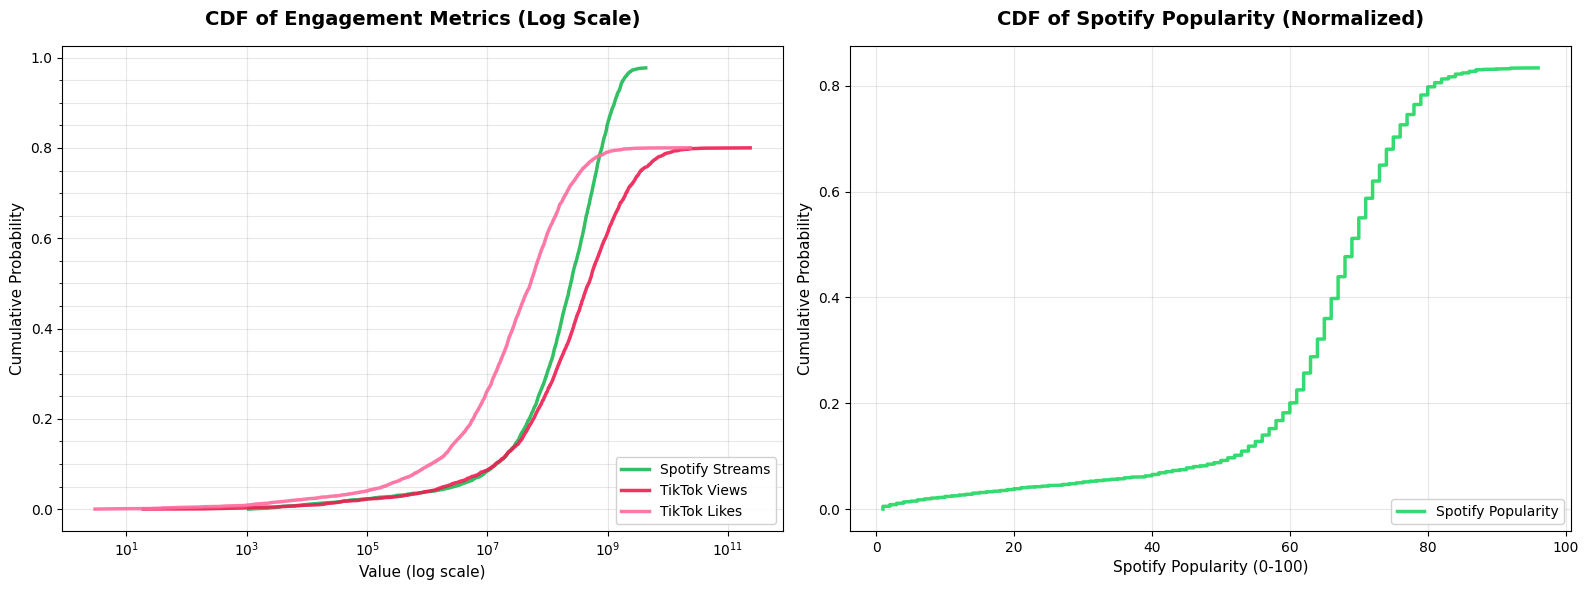

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#left: 
ax1 = axes[0]

# Spotify Streams - Dunkelgrün (LOG)
spotify_sorted = np.sort(spotify_songs['Spotify_Streams'])
spotify_cdf = np.arange(1, len(spotify_sorted) + 1) / len(spotify_sorted)
ax1.plot(spotify_sorted, spotify_cdf, linewidth=2.5, color='#1DB954', 
         label='Spotify Streams', alpha=0.9)

# TikTok Views - Dunkelrot (LOG)
tiktok_views_sorted = np.sort(spotify_songs['TikTok_Views'])
tiktok_views_cdf = np.arange(1, len(tiktok_views_sorted) + 1) / len(tiktok_views_sorted)
ax1.plot(tiktok_views_sorted, tiktok_views_cdf, linewidth=2.5, color='#EE1D52', 
         label='TikTok Views', alpha=0.9)

# TikTok Likes - Rosa (LOG)
tiktok_likes_sorted = np.sort(spotify_songs['TikTok_Likes'])
tiktok_likes_cdf = np.arange(1, len(tiktok_likes_sorted) + 1) / len(tiktok_likes_sorted)
ax1.plot(tiktok_likes_sorted, tiktok_likes_cdf, linewidth=2.5, color='#FF6B9D', 
         label='TikTok Likes', alpha=0.9)

ax1.set_title('CDF of Engagement Metrics (Log Scale)', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Value (log scale)', fontsize=11)
ax1.set_ylabel('Cumulative Probability', fontsize=11)
ax1.set_xscale('log')  # Log-Scale
ax1.legend(loc='lower right', fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3, which='both')
ax1.minorticks_on()

# right: Popularity
ax2 = axes[1]

# Spotify Popularity - Hellgrün (KEIN LOG)
spotify_pop_sorted = np.sort(spotify_songs['Spotify_Popularity'])
spotify_pop_cdf = np.arange(1, len(spotify_pop_sorted) + 1) / len(spotify_pop_sorted)
ax2.plot(spotify_pop_sorted, spotify_pop_cdf, linewidth=2.5, color='#1ED760', 
         label='Spotify Popularity', alpha=0.9)

ax2.set_title('CDF of Spotify Popularity (Normalized)', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Spotify Popularity (0-100)', fontsize=11)
ax2.set_ylabel('Cumulative Probability', fontsize=11)
# KEIN LOG - bereits normalisiert auf 0-100!
ax2.legend(loc='lower right', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cdf_log_vs_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

Left Panel (Log-Transformed Engagement Metrics):
All three metrics demonstrate classic power-law distributions even after log transformation, confirming the winner-take-all dynamics in viral content ecosystems

Right Panel (Spotify Popularity - Normalized):
The S-curve shape indicates an approximately normal distribution on the 0-100 scale, with the steepest rise between 50-80 points where most songs cluster

##### Summary statistics table

In [58]:
# Select relevant columns
data = spotify_songs[['Spotify_Streams', 'Spotify_Popularity', 'TikTok_Views', 'TikTok_Likes']]

# Calculate summary statistics
summary_stats = data.describe().T[['count', 'mean', 'std', 'min', 'max']]

# Calculate correlations with other variables (using Spearman due to skewness)
correlations = data.corr(method='spearman')

# Merge summary statistics and correlation information
summary_table = summary_stats.join(correlations, lsuffix='_stat')

# Rename the columns for clarity
summary_table.columns = [
    'N',
    'Mean', 
    'S.D.',
    'Min',
    'Max',
    '(1)',
    '(2)',
    '(3)',
    '(4)'
]

# Rename row index
summary_table = summary_table.rename(index={
    'Spotify_Streams': "(1) Spotify Streams",
    'Spotify_Popularity': "(2) Spotify Popularity", 
    'TikTok_Views': "(3) TikTok Views",
    'TikTok_Likes': "(4) TikTok Likes"
})

# Print the summary table
summary_table = np.round(summary_table, 2)
print(summary_table)

                             N          Mean          S.D.     Min  \
(1) Spotify Streams     4386.0  4.324765e+08  5.226338e+08  1071.0   
(2) Spotify Popularity  3742.0  6.363000e+01  1.604000e+01     1.0   
(3) TikTok Views        3591.0  1.156642e+09  5.891538e+09    19.0   
(4) TikTok Likes        3592.0  1.123860e+08  5.511663e+08     3.0   

                                 Max   (1)   (2)   (3)   (4)  
(1) Spotify Streams     4.281469e+09  1.00  0.52  0.32  0.38  
(2) Spotify Popularity  9.600000e+01  0.52  1.00  0.12  0.16  
(3) TikTok Views        2.332323e+11  0.32  0.12  1.00  0.98  
(4) TikTok Likes        2.347422e+10  0.38  0.16  0.98  1.00  


#### 3.4.2 Bivariate Analysis

Now we will into the interaction between our song popularity metrics. As Spotify_Popularity is already normalized, we will use this as dependent variable, and see how TikTok influences the Popularity of Songs in Spotify.

##### Log-Log Scatter Plots

The log-transformed scatter plots visualize the relationship between engagement metrics and Spotify Popularity, revealing correlation strength and potential non-linear patterns such as ceiling effects at extreme TikTok engagement levels.

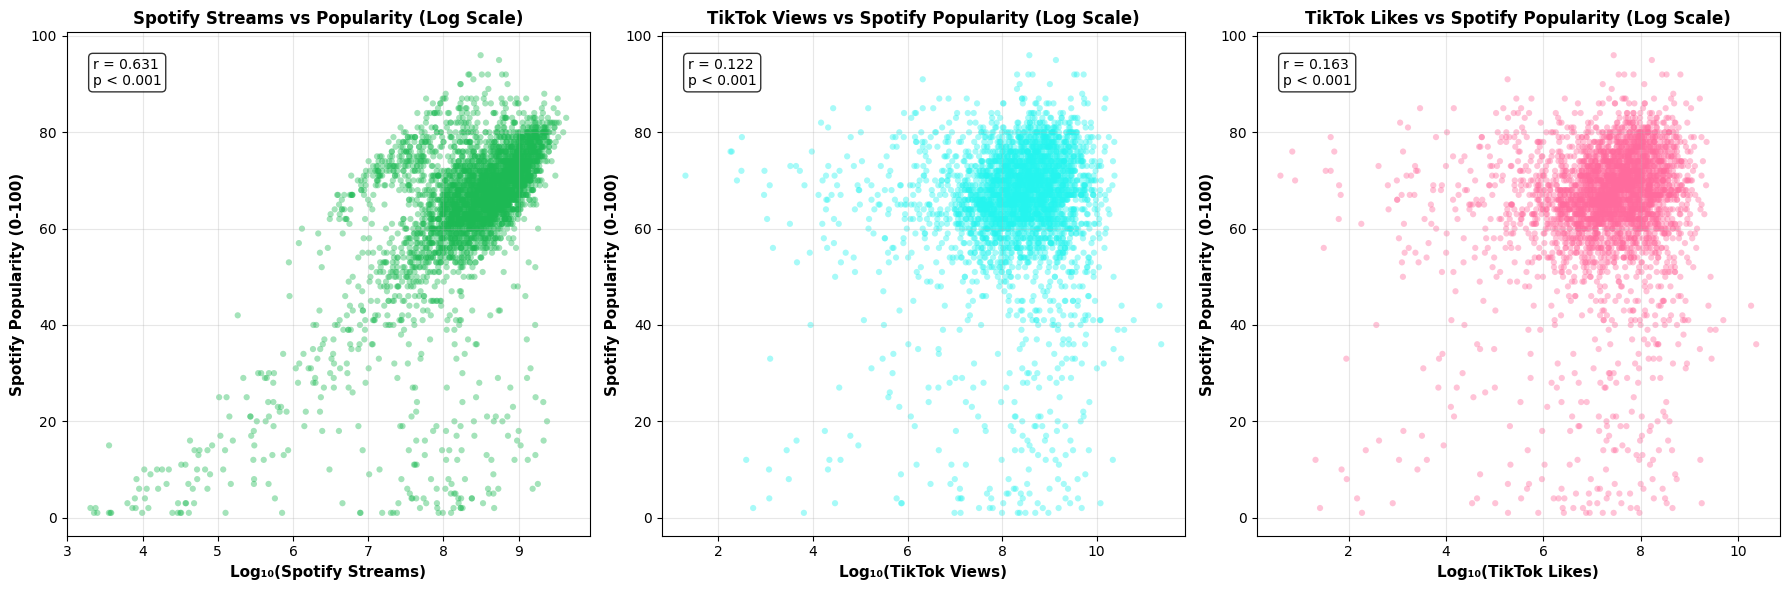

In [59]:
# Log-transformed scatter plots to reveal relationships
# These plots show the distribution of data points and correlation strength
# between log-transformed engagement metrics and Spotify Popularity

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Prepare log-transformed data
log_spotify_streams = np.log10(spotify_songs['Spotify_Streams'] + 1)
log_tiktok_views = np.log10(spotify_songs['TikTok_Views'] + 1)
log_tiktok_likes = np.log10(spotify_songs['TikTok_Likes'] + 1)
spotify_popularity = spotify_songs['Spotify_Popularity']

# Remove NaN values
def clean_data(x, y):
    mask = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    return x[mask], y[mask]

# 1. Log Spotify Streams vs Spotify Popularity
ax1 = axes[0]
x1, y1 = clean_data(log_spotify_streams, spotify_popularity)
ax1.scatter(x1, y1, alpha=0.4, s=20, color='#1DB954', edgecolors='none')

# Correlation
corr1, pval1 = stats.pearsonr(x1, y1)
ax1.text(0.05, 0.95, f'r = {corr1:.3f}\np < 0.001' if pval1 < 0.001 else f'r = {corr1:.3f}\np = {pval1:.3f}',
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax1.set_xlabel('Log₁₀(Spotify Streams)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Spotify Popularity (0-100)', fontsize=11, fontweight='bold')
ax1.set_title('Spotify Streams vs Popularity (Log Scale)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Log TikTok Views vs Spotify Popularity
ax2 = axes[1]
x2, y2 = clean_data(log_tiktok_views, spotify_popularity)
ax2.scatter(x2, y2, alpha=0.4, s=20, color='#25F4EE', edgecolors='none')

# Correlation
corr2, pval2 = stats.pearsonr(x2, y2)
ax2.text(0.05, 0.95, f'r = {corr2:.3f}\np < 0.001' if pval2 < 0.001 else f'r = {corr2:.3f}\np = {pval2:.3f}',
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2.set_xlabel('Log₁₀(TikTok Views)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Spotify Popularity (0-100)', fontsize=11, fontweight='bold')
ax2.set_title('TikTok Views vs Spotify Popularity (Log Scale)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Log TikTok Likes vs Spotify Popularity
ax3 = axes[2]
x3, y3 = clean_data(log_tiktok_likes, spotify_popularity)
ax3.scatter(x3, y3, alpha=0.4, s=20, color='#FF6B9D', edgecolors='none')

# Correlation
corr3, pval3 = stats.pearsonr(x3, y3)
ax3.text(0.05, 0.95, f'r = {corr3:.3f}\np < 0.001' if pval3 < 0.001 else f'r = {corr3:.3f}\np = {pval3:.3f}',
         transform=ax3.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3.set_xlabel('Log₁₀(TikTok Likes)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Spotify Popularity (0-100)', fontsize=11, fontweight='bold')
ax3.set_title('TikTok Likes vs Spotify Popularity (Log Scale)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('scatter_plots_log_transformed.png', dpi=300, bbox_inches='tight')
plt.show()

TikTok metrics demonstrate surprisingly weak correlations (TikTok Views: r = 0.122, TikTok Likes: r = 0.163). The considerable scatter and weak correlations for TikTok engagement suggest that viral TikTok success does not reliably translate into proportional Spotify popularity, providing initial visual evidence supporting our hypothesis regarding diminishing returns at high TikTok engagement levels.

##### Correlation Plots

To further look into the corrulation lets look at a heatmap. We chose Spearman because:
- Spearman is more robust against outliers
- Spearman captures any monotonic relationship (where variables consistently increase or decrease together, even if not perfectly linear)
-  Spearman does not require normally distributed data, which is appropriate given the persistent skewness in our engagement metrics

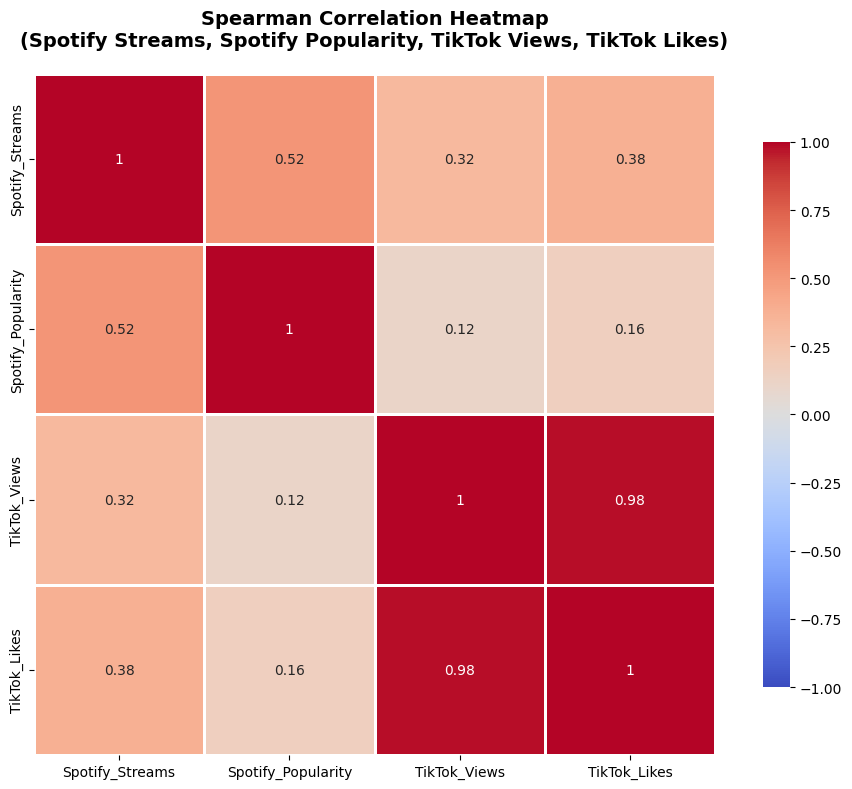

In [60]:
# Select key variables for correlation analysis
key_vars = ['Spotify_Streams', 'Spotify_Popularity', 'TikTok_Views', 'TikTok_Likes']

# Compute the Spearman correlation matrix (chosen method)
correlation_matrix = spotify_songs[key_vars].corr(method='spearman') 

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})

# Set the title and labels
plt.title('Spearman Correlation Heatmap\n(Spotify Streams, Spotify Popularity, TikTok Views, TikTok Likes)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

The correlation matrix reveals also what we already saw in the scatter plots:
- Spotify Streams demonstrates a moderate positive correlation with Spotify Popularity (r = 0.52), confirming that platform-native engagement translates relatively well into algorithmic popularity scores.
- TikTok metrics show as in the scatter plots surprisingly weak correlations with Spotify success: TikTok Views correlates at only r = 0.12 and TikTok Likes at r = 0.16 with Spotify Popularity, suggesting minimal predictive power.

The near-perfect correlation between TikTok Views and Likes (r = 0.98) indicates these metrics are essentially measuring the same underlying construct, while their weak relationship with Spotify outcomes suggests a fundamental disconnect between TikTok virality and sustained streaming success. This asymmetry provides strong preliminary evidence for our H1 hypothesis regarding diminishing returns, as extreme TikTok engagement appears to offer limited additional benefit for long-term Spotify performance compared to platform-native metrics.

##### Covariances

In [61]:
print("\nCovariance Matrix (Spotify Streams, TikTok Views, Spotify Popularity, TikTok Likes):")
print(spotify_songs[['Spotify_Streams', 'TikTok_Views', 'Spotify_Popularity', 'TikTok_Likes']].cov())


Covariance Matrix (Spotify Streams, TikTok Views, Spotify Popularity, TikTok Likes):
                    Spotify_Streams  TikTok_Views  Spotify_Popularity  \
Spotify_Streams        2.731461e+17  9.729928e+16        3.163786e+09   
TikTok_Views           9.729928e+16  3.471022e+19       -5.179712e+09   
Spotify_Popularity     3.163786e+09 -5.179712e+09        2.572087e+02   
TikTok_Likes           1.304346e+16  3.223614e+18       -3.819434e+08   

                    TikTok_Likes  
Spotify_Streams     1.304346e+16  
TikTok_Views        3.223614e+18  
Spotify_Popularity -3.819434e+08  
TikTok_Likes        3.037843e+17  


The covariance matrix shows that TikTok Views exhibits approximately 100x greater variance than Spotify Streams (3.47×10¹⁹ vs 2.73×10¹⁷), while TikTok Likes shows comparable variance to Spotify Streams. This suggests TikTok Views are far more volatile and unpredictable than streaming success on Spotify. The negative covariance between TikTok Views and Spotify Popularity (-5.18×10⁹) combined with the weak positive correlation (r = 0.12) indicates that while there is a slight rank-order relationship, the actual magnitude relationship is inconsistent - high TikTok Views do not reliably translate into proportionally high Spotify success. This may support our ceiling effect hypothesis.

### 3.5 Key Findings

CHECK NUMBERS


The exploratory data analysis confirms that our research question and hypotheses are well-motivated and worth pursuing:

- Dataset contains **3,597 songs** with complete data across all key variables, providing sufficient statistical power

- **Extreme right-skewness across all raw engagement metrics** (Mean/Median ratios: 1.9-4.4x), confirming power-law distribution typical of viral content ecosystems

- **TikTok metrics show surprisingly weak correlations with Spotify Popularity (r = 0.12-0.16)**, despite TikTok Views and Likes being near-perfectly correlated with each other (r = 0.98), suggesting TikTok virality does not translate effectively to Spotify success

- Spotify Streams demonstrates moderate correlation with Spotify Popularity (r = 0.52), indicating platform-native engagement is a stronger predictor than cross-platform virality

- Log-transformed scatter plots reveal **high variance in Spotify outcomes even at extreme TikTok engagement levels**, visually suggesting a ceiling effect where additional TikTok virality yields diminishing Spotify returns

- Due to multicollinearity (r = 0.98), **we will use only TikTok Views (not Likes) in subsequent analyses to avoid redundancy**

**Conclusion:** The exploratory analysis provides preliminary evidence supporting both hypotheses, justifying progression to K-means clustering (H1) and polynomial regression (H2) for formal hypothesis testing.

## 4. Method 1: Cluster Analysis

### Objective
The goal of this analysis is to identify distinct groups of songs based on their streaming performance and TikTok engagement metrics.  
By using clustering, we aim to uncover hidden patterns among songs. For instance, groups of tracks that perform well on both Spotify and TikTok, or those that are successful only on one of the two platforms.

---

### 4.1 Data Preparation
We selected the following numerical variables to represent both **Spotify** and **TikTok** performance:

- **Spotify Streams**: total number of streams on Spotify.  
- **Spotify Popularity**: internal popularity score assigned by Spotify.  
- **Spotify Playlist Count**: number of playlists including the track.  
- **TikTok Posts**: number of TikTok posts using the song.  
- **TikTok Likes**: total likes generated by those posts.  
- **TikTok Views**: total views on TikTok related to the track.  
- **Track Score**: overall score that summarizes performance across platforms.

All variables are numerical but expressed on very different scales.  
To ensure that each variable contributes equally to the clustering, we perform **standardization** (z-score scaling).

---

### 4.2 Methodology
We apply the **K-Means** clustering algorithm, which partitions the dataset into *k* distinct groups based on feature similarity.

Steps:
1. Standardize variables (mean = 0, std = 1).  
2. Use the **Elbow Method** and **Silhouette Score** to identify the optimal number of clusters.  
3. Apply the K-Means algorithm with the selected number of clusters.  
4. Analyze the resulting clusters to understand their meaning and practical relevance.


#### 4.1.1 Import libraries and prepare data
This section imports all required packages and loads the cleaned dataset containing Spotify track metrics and TikTok activity data. After importing, initial data cleaning steps are applied, including formatting the release date and handling missing or non-numeric entries. This ensures the dataset is properly structured and ready for robust downstream analysis.

In [62]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the dataset
df = pd.read_csv("spotify_cleaned.csv")

# Display the first few rows to make sure the columns are correct
df.head()


,Track,Artist,Spotify Streams,Spotify Popularity,Spotify Playlist Count,TikTok Posts,TikTok Likes,TikTok Views,Track Score,All Time Rank
0,MILLION DOLLAR BABY,Tommy Richman,3.904709e+08,92.0,30716.0,5767700.0,6.515659e+08,5.332282e+09,725.4,1
1,Not Like Us,Kendrick Lamar,3.237039e+08,92.0,28113.0,674700.0,3.522355e+07,2.083390e+08,545.9,2
2,i like the way you kiss me,Artemas,6.013093e+08,92.0,54331.0,3025400.0,2.751542e+08,3.369121e+09,538.4,3
3,Flowers,Miley Cyrus,2.031281e+09,85.0,269802.0,7189811.0,1.078758e+09,1.460373e+10,444.9,4
4,Houdini,Eminem,1.070349e+08,88.0,7223.0,16400.0,NaN,NaN,423.3,5


#### 4.1.2 Select variables for clustering and scale them
In this phase, the core quantitative variables for clustering (such as streams, popularity scores and TikTok engagement metrics) are selected for the model. Since these features exist on substantially different scales, normalization is performed to standardize the data, allowing for meaningful comparisons and preventing larger numerical values from dominating the clustering results.

In [63]:
# Select relevant numerical features for clustering
features = [
    'Spotify Streams',
    'Spotify Popularity',
    'Spotify Playlist Count',
    'TikTok Posts',
    'TikTok Likes',
    'TikTok Views',
    'Track Score'
]

X = df[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to DataFrame for readability
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Check standardized data
X_scaled_df.head()


,Spotify Streams,Spotify Popularity,Spotify Playlist Count,TikTok Posts,TikTok Likes,TikTok Views,Track Score
0,-0.080382,1.769031,-0.411984,1.980438,0.978389,0.708851,17.703778
1,-0.208148,1.769031,-0.448734,-0.109382,-0.140018,-0.160983,13.054315
2,0.323079,1.769031,-0.078579,0.855185,0.295357,0.375587,12.860048
3,3.059477,1.332502,2.963512,2.563976,1.753566,2.282758,10.438182
4,-0.622766,1.519586,-0.743666,-0.379503,NaN,NaN,9.878693


#### 4.2.1 Determine optimal number of clusters (Elbow method)
This code applies the **Elbow Method** to help determine the most appropriate number of clusters for the analysis. The method runs the K-Means algorithm for different values of k (from 2 to 10) and records the “inertia” for each model, which measures how well the data fits within the clusters. These inertia values are then plotted against the number of clusters. The point at which the curve starts to flatten (forming an “elbow” shape) suggests the best balance between model simplicity and cluster compactness.


In [64]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []  # measures how well the data fits each number of clusters
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In the resulting plot, we observe a visible “elbow” around 3–5 clusters. This suggests that our dataset likely contains a few main groups of songs that share distinct performance patterns across Spotify and TikTok.

#### 4.2.2 Validate the number of clusters with the Silhouette Score
After identifying a potential range of 3–5 clusters from the Elbow Method, we further validate our choice using the **Silhouette Score**. This metric measures how similar each data point is to its own cluster compared to other clusters, with values closer to 1 indicating better-defined clusters. By calculating the Silhouette Score for different values of k, we aim to confirm whether our elbow observation corresponds to a configuration that provides high cohesion within clusters and clear separation between them.

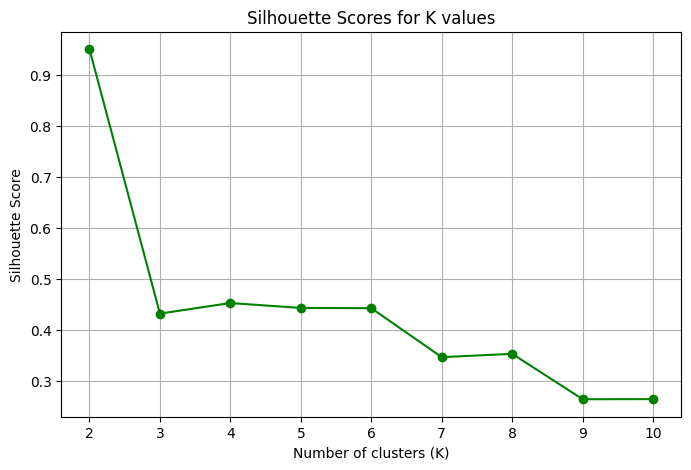

In [ ]:
# Evaluate silhouette scores for different K
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8,5))
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Scores for K values')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

The silhouette analysis shows that the score reaches its maximum value around **k = 3**, confirming that three clusters provide the best balance between compactness and separation. This supports the result of the Elbow Method and suggests that our dataset can be meaningfully divided into three main groups of songs.

#### 4.2.3 Apply K-Means and visualize clusters

After identifying the optimal number of clusters, we apply the **K-Means algorithm** to group songs based on their standardized performance metrics. Each cluster represents a different success profile: for instance, some clusters may include songs that went viral on TikTok but didn’t convert strongly on Spotify, while others may group more established Spotify hits with limited social engagement. 
We then add the resulting cluster labels to the dataset, stored in a new column named “Cluster”. Displaying the number of items per cluster allows us to verify that all clusters are adequately represented and that no group contains too few observations, which could indicate an imbalance or an unsuitable k value


In [ ]:
# Choose the optimal K based on Elbow and Silhouette results
optimal_k = 3  # change if another value looks better from the plots

# Apply K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Check cluster distribution
df['Cluster'].value_counts()


Cluster
1    2389
0     768
2       2
Name: count, dtype: int64

The distribution of songs across clusters appears heterogeneous, confirming the existence of multiple distinct success profiles within the dataset.

#### 4.2.4 Cluster interpretation (descriptive analysis)

The resulting clusters are examined in depth by analyzing the distribution of each variable within the groups. The objective is to interpret cluster characteristics, delineate key differences between them and identify recurring profiles of tracks or artists based on their success and engagement patterns on TikTok and Spotify. <br> 
The code calculates the mean value of each variable within every cluster, allowing us to identify the main characteristics of each group. For example, one group might include songs with high TikTok engagement but fewer Spotify streams, representing viral hits that haven’t yet translated into listening success. By comparing these averages, we can uncover patterns that explain how success on TikTok and Spotify may interact. 


In [ ]:
# Analyze the characteristics of each cluster
cluster_summary = df.groupby('Cluster')[features].mean().round(2)
cluster_summary


,Spotify Streams,Spotify Popularity,Spotify Playlist Count,TikTok Posts,TikTok Likes,TikTok Views,Track Score
Cluster,,,,,,,
0,1.290028e+09,74.44,181818.68,1259569.68,1.779095e+08,1.751129e+09,68.92
1,3.104087e+08,61.40,48353.20,800174.31,8.664917e+07,9.015248e+08,33.87
2,1.390205e+07,40.00,10056.50,33643867.50,2.094846e+10,2.240381e+11,40.35


The summary table reveals clear behavioral differences between clusters. For instance:
- **Cluster 0**: contains songs with exceptionally high visibility and engagement on TikTok (posts, likes, views), which also have strong, though not the very highest, streaming figures on Spotify. These are likely tracks that have gone viral on social media and succeeded in achieving significant, but not maximum, listening success on Spotify.
- **Cluster 1**: represents songs with the largest number of streams and playlist placements on Spotify, but lower popularity scores and more moderate engagement on TikTok. These are probably mainstream or established hits that gain their success more through Spotify’s ecosystem—playlists, algorithmic recommendations, loyal listenership—than through viral trends on TikTok.
- **Cluster 2**: consists of tracks with lower popularity on Spotify but relatively high activity on TikTok—especially likes and views. This group likely includes viral TikTok phenomena that don’t translate to high playlist counts or long-term streaming status on Spotify, possibly reflecting more niche or short-lived trends.